# TD3 PHYSIO : Modèles hémodynamiques

In [3]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fmin
import matplotlib.pyplot as plt

def inletP(t) :
    Ampli = 40 #mmHg
    Base = 80 #mmHg
    Tc = 0.2 #contraction phase
    Tr = 0.7 #relaxation phase
    Per = 1 # HR in second
    
    modt = t%Per

    if(0<= modt and modt <= Tc) :
        return Base + Ampli * 0.5 * (1 - np.cos(np.pi * modt / Tc) )
    elif(Tc < modt <= Tc + Tr) :
        return Base + Ampli * 0.5 * (1 + np.cos(np.pi * (modt-Tc) / Tr) )
    else :
        return Base


## Développer un modèle hémodynamique

1. En utilisant votre cours, donner les équations d’un circuit RCR représentant un ensemble de vaisseaux sanguins

Pin - P = RpQinP - Pout = RdQout C*dPdt = Qin- Qout
C*dpdt = (Pin -P)/Rp - (P-Pout)/Rd

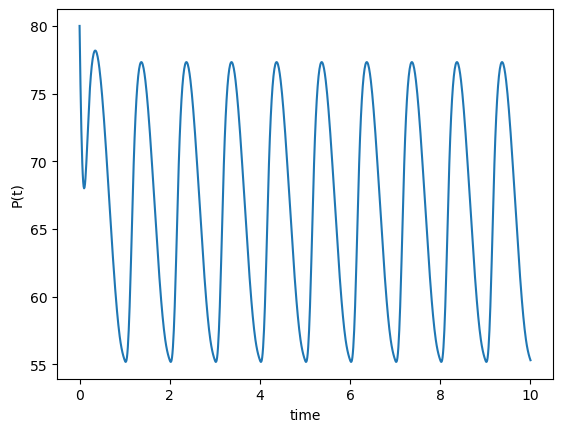

In [42]:
Pout = 3
C = 1e-3
Rp = 160
Rd = 320
t = np.linspace(0,10,1001)
y0 = 80

def hmodel(P,t,Pout,C,Rp,Rd):
    dpdt = (inletP(t)-P)/(C*Rp) - (P-Pout)/(C*Rd)
    return dpdt

P = odeint(hmodel,y0,t,args=(Pout,C,Rp,Rd))

plt.plot(t,P)
plt.xlabel('time')
plt.ylabel('P(t)')
plt.show()

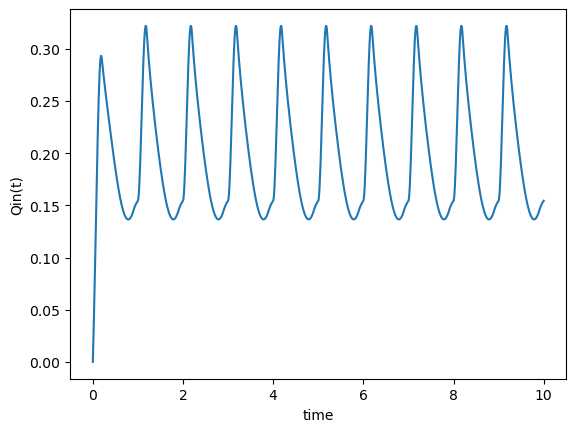

In [43]:
def computeQ(T,P,Rp):
    Pin = []
    Qin = []
    for t in range(len(T)):
        Pin.append(inletP(T[t]))
        Qin.append((Pin[t]-P[t])/Rp)
    return np.array(Qin)

Qin = computeQ(t,P,Rp)

plt.plot(t,Qin)
plt.xlabel('time')
plt.ylabel('Qin(t)')
plt.show()


## Estimation des paramètres du modèle

1. Avec le modèle RCR précédent, choisir des valeurs de paramètres et simuler la courbe de flux d’entrée Qin

In [12]:
Pout = 3
C = 1e-3
Rp = 160
Rd = 320
t = np.linspace(0,10,1001)
y0 = 80

2. Conserver la dernière période de Qin (la durée d’une période est “cachée” dans la fonction inletP)

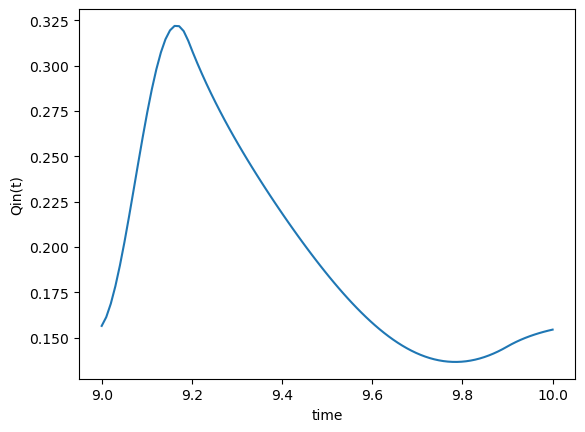

In [44]:
Qp = Qin[-100:]
tp = np.linspace(9,10,100)
plt.plot(tp,Qp)
plt.xlabel('time')
plt.ylabel('Qin(t)')
plt.show()

3. Ajouter un bruit à ce flux pour obtenir une donnée synthétique (simulation du modèle + bruit) et représenter les données bruitées et non bruitées sur la même figure (ajuster le niveau de bruit)

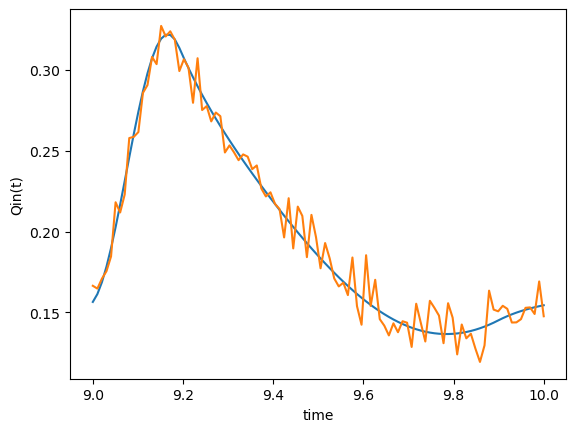

In [45]:
bruit = Qp + np.random.normal(0,0.01,100).reshape(100,1)
plt.plot(tp,Qp)
plt.plot(tp,bruit)
plt.xlabel('time')
plt.ylabel('Qin(t)')
plt.show()


4. Ecrire une fonction distance(param, x0, t, obs)

In [51]:
def distance(param,obs,t,x0):
    Rp,C,Rd = param
    Pout = 3
    P = odeint(hmodel,x0,t,args=(Pout,C,Rp,Rd))
    Qin = computeQ(t,P,Rp)
    d = np.sum((obs-Qin)**2)
    return d


5. Avec vos données bruitées, et la condition initiale choisie pour les génerer, estimer les valeurs des paramètres du modèle, comparer votre estimation avec les valeurs de paramètres choisies pour générer la donnée synthétique.

In [54]:
x0 = P[-100]
param = [16,1e-2,32]
p = fmin(distance,param,args=(bruit,np.linspace(0,1,100),x0))
print(p)



C:\Users\3701883\AppData\Local\Temp\16\ipykernel_18820\206290611.py:6: RuntimeWarning: overflow encountered in square
  d = np.sum((obs-Qin)**2)
C:\Users\3701883\AppData\Local\Temp\16\ipykernel_18820\859798940.py:9: RuntimeWarning: overflow encountered in subtract
  dpdt = (inletP(t)-P)/(C*Rp) - (P-Pout)/(C*Rd)


Optimization terminated successfully.
         Current function value: 0.010131
         Iterations: 166
         Function evaluations: 294
[1.49762976e+02 8.66839935e-04 3.29283024e+02]


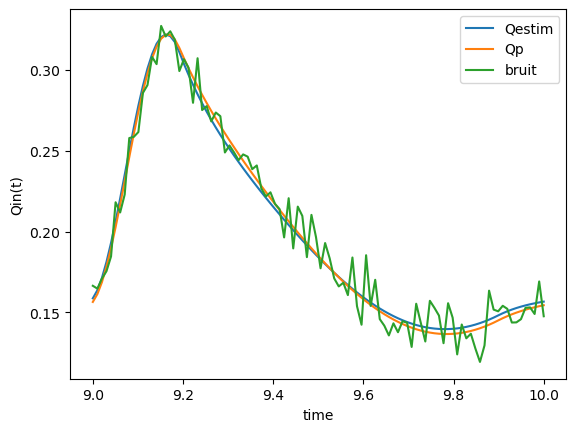

In [55]:
Pestim = odeint(hmodel,y0,t,args=(Pout,p[1],p[0],p[2]))
Qestim = computeQ(t,Pestim,p[0])
Qpestim = Qestim[-100:]
tpestim = np.linspace(9,10,100)

bruitest = Qpestim + np.random.normal(0,0.01,100).reshape(100,1)
plt.plot(tpestim,Qpestim,label = "Qestim")
#plt.plot(tpestim,bruitest,label ="bruitest")
plt.plot(tp,Qp,label = "Qp")
plt.plot(tp,bruit, label="bruit")
plt.xlabel('time')
plt.ylabel('Qin(t)')
plt.legend()
plt.show()

## Avec une mesure réelle

Nous avons fait des mesures chez un animal de flux et de pression au cours du temps dans l’artère hépatique (entrée du foie) (PressionAnim1.txt et FlowAnim1.txt disponibles sur Moodle). Nous souhaitons savoir si nous pouvons représenter l’arbre artériel hépatique par un circuit RCR et si oui, quelles sont les valeurs des résistances et de la capacitance. Comme précédemment nous supposons que la pression en entrée est connue et que le flux d’entrée est observé. La pression de sortie est supposée constante et nulle.


1. Récupérer sur Moodle, les fichiers de données PressionAnim1.txt et le code qui donne la pression en entrée aux temps t qui est dans le fichier experimentalP.py

In [56]:
from scipy import interpolate

Pdata = np.loadtxt('PressionAnim1.txt', skiprows=1)

tP = Pdata[:,0]
Pobs = Pdata[:,1]

interpP1 = interpolate.interp1d(tP, Pobs)

def expP(t) :  
    return( interpP1(t%tP[-1]) )